In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
## import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
#import pyLDAvis.gensim
#pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Variables


In [3]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [4]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [5]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

Dropping 0 entries of corpus, due to nan ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
16it [00:00, 155.30it/s]

Starting tokenization ...


1261it [00:05, 219.00it/s]


### tfidf

In [6]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

# find optimal k
TODO

# Clustering
Start with default params and tied for the covariance type because of the high CPU and RAM usage with full.
TODO: try different params

In [7]:
def fit_model(model, corpus):
    model.fit(corpus)

def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, vectorizer, corpus, labels, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i)
        idx = np.where(labels == i)[0]
        if not idx.any():
            print(f"no documents in cluster {i}")
        else:
            vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[idx])
            top_words = get_top_words(vectorizer, tfidf_corpus)
            print(top_words)
            clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters
    
model = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model, tfidf_corpus.toarray())
labels = model.predict(tfidf_corpus.toarray())

clusters = print_and_get_clusters(model, vectorizer, corpus, labels)


Top terms per cluster:
Cluster 0:
('algorithm', 'method', 'problem', 'regression', 'data', 'convex', 'function', 'gradient', 'estimator', 'rate')


Cluster 1:
('learning', 'data', 'algorithm', 'model', 'machine', 'label', 'problem', 'method', 'framework', 'library')


Cluster 2:
('feature', 'selection', 'learning', 'data', 'model', 'method', 'algorithm', 'set', 'gesture', 'forest')


Cluster 3:
('online', 'algorithm', 'method', 'learning', 'problem', 'convergence', 'order', 'machine', 'stochastic', 'second')


Cluster 4:
('model', 'time', 'data', 'series', 'algorithm', 'method', 'learning', 'process', 'regression', 'prediction')


Cluster 5:
('kernel', 'learning', 'data', 'regression', 'algorithm', 'function', 'method', 'rate', 'density', 'based')


Cluster 6:
('loss', 'function', 'multiclass', 'learning', 'regression', 'algorithm', 'problem', 'risk', 'class', 'result')


Cluster 7:
('algorithm', 'constraint', 'regret', 'problem', 'optimization', 'bound', 'bandit', 'learning', 'set', '

some words words are similar to kmeans. But there are a lot of words which are new. But the "buzzwords" are the same and the composition of words defining a cluster are very similar to kmeans.






# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


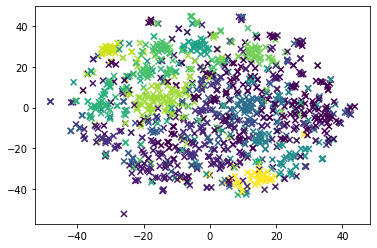

In [8]:
def plot(model, corpus, labels, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=labels, marker='x')
    plt.show()
plot(model, tfidf_corpus, labels)

no clusters visible

# Remove words which appear often in all clusters

In [9]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 13, 'method': 12, 'learning': 12, 'data': 11, 'model': 9, 'problem': 7, 'regression': 4, 'function': 4, 'based': 4, 'convex': 2, 'rate': 2, 'machine': 2, 'set': 2, 'process': 2, 'density': 2, 'bound': 2, 'graph': 2, 'gaussian': 2, 'variable': 2, 'gradient': 1, 'estimator': 1, 'label': 1, 'framework': 1, 'library': 1, 'feature': 1, 'selection': 1, 'gesture': 1, 'forest': 1, 'online': 1, 'convergence': 1, 'order': 1, 'stochastic': 1, 'second': 1, 'time': 1, 'series': 1, 'prediction': 1, 'kernel': 1, 'loss': 1, 'multiclass': 1, 'risk': 1, 'class': 1, 'result': 1, 'constraint': 1, 'regret': 1, 'optimization': 1, 'bandit': 1, 'clustering': 1, 'cluster': 1, 'hierarchical': 1, 'spectral': 1, 'network': 1, 'neural': 1, 'community': 1, 'node': 1, 'layer': 1, 'graphical': 1, 'matrix': 1, 'rank': 1, 'low': 1, 'completion': 1, 'norm': 1, 'inference': 1, 'latent': 1, 'variational': 1, 'bayesian': 1, 'causal': 1, 'effect': 1, 'discovery': 1,

most common words are similar to kmeans

In [10]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [11]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
19it [00:00, 187.91it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:05, 218.76it/s]


In [12]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [13]:
model_stopwords = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_stopwords, tfidf_corpus_stopwords.toarray())
labels_stopwords = model_stopwords.predict(tfidf_corpus_stopwords.toarray())

clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, corpus_stopwords, labels_stopwords)

Top terms per cluster:
Cluster 0:
('kriging', 'toolbox', 'jstacs', 'topic', 'object', 'issue', 'preface', 'special', 'active', 'manifold')


Cluster 1:
('inference', 'gaussian', 'process', 'bayesian', 'variational', 'approach', 'prior', 'approximation', 'latent', 'distribution')


Cluster 2:
('density', 'estimator', 'derivative', 'estimation', 'regression', 'clustering', 'kernel', 'cluster', 'function', 'based')


Cluster 3:
('policy', 'iteration', 'action', 'based', 'gradient', 'problem', 'task', 'search', 'function', 'value')


Cluster 4:
('kernel', 'regression', 'function', 'based', 'mean', 'rate', 'approximation', 'space', 'distributed', 'bound')


Cluster 5:
('problem', 'stochastic', 'optimization', 'gradient', 'function', 'convex', 'convergence', 'non', 'descent', 'objective')


Cluster 6:
('causal', 'effect', 'variable', 'set', 'discovery', 'approach', 'inference', 'observational', 'graph', 'cause')


Cluster 7:
('graph', 'problem', 'class', 'distribution', 'sample', 'set', 'bas

In [14]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 9, 'regression': 5, 'function': 5, 'based': 5, 'graph': 4, 'approach': 3, 'bound': 3, 'set': 3, 'toolbox': 2, 'inference': 2, 'approximation': 2, 'distribution': 2, 'estimation': 2, 'clustering': 2, 'kernel': 2, 'cluster': 2, 'gradient': 2, 'rate': 2, 'convex': 2, 'variable': 2, 'feature': 2, 'rank': 2, 'kriging': 1, 'jstacs': 1, 'topic': 1, 'object': 1, 'issue': 1, 'preface': 1, 'special': 1, 'active': 1, 'manifold': 1, 'gaussian': 1, 'process': 1, 'bayesian': 1, 'variational': 1, 'prior': 1, 'latent': 1, 'density': 1, 'estimator': 1, 'derivative': 1, 'policy': 1, 'iteration': 1, 'action': 1, 'task': 1, 'search': 1, 'value': 1, 'mean': 1, 'space': 1, 'distributed': 1, 'stochastic': 1, 'optimization': 1, 'convergence': 1, 'non': 1, 'descent': 1, 'objective': 1, 'causal': 1, 'effect': 1, 'discovery': 1, 'observational': 1, 'cause': 1, 'class': 1, 'sample': 1, 'result': 1, 'lasso': 1, 'high': 1, 'selection': 1, 'dimensional': 1, 'n

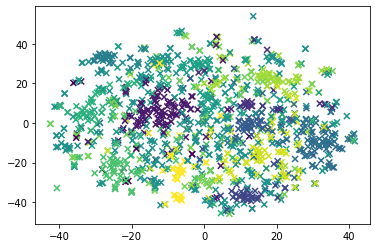

In [15]:
plot(model_stopwords, tfidf_corpus_stopwords, labels_stopwords)

Cluster looks a little bit better than before? But still not good. 

# LSA
- With LSA the calculation time is much less.
- TODO: find optimal n_components

In [16]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

test for optimal n_components

In [29]:
def calc_scores_arr(corpus, model, labels):
    return metrics.silhouette_score(corpus, labels, metric='euclidean'), metrics.calinski_harabasz_score(corpus, labels), metrics.davies_bouldin_score(corpus, labels)

def calc_scores(corpus, model, labels):
    return calc_scores_arr(corpus.toarray(), model, labels)

def plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(n, silhouettes_scores)
    ax1.set_title('silhouettes_score')
    ax2.plot(n, calinski_harabasz_scores, label="calinski_harabasz_scores")
    ax2.set_title('calinski_harabasz_scores')
    ax3.plot(n, davies_bouldin_scores, label="davies_bouldin_scores")
    ax3.set_title('davies_bouldin_scores')
    plt.show()
    

def find_n_components_lsa():
    n = [2,5,10,15,20,25,30]
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        X, svd = get_lsa_transformation(n_component, tfidf_corpus)
        model_lsa = GaussianMixture(n_components=num_topics, covariance_type="tied")
        fit_model(model_lsa, X)
        labels_lsa = model_lsa.predict(X)
        score = list(calc_scores(tfidf_corpus, model_lsa, labels_lsa))

        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

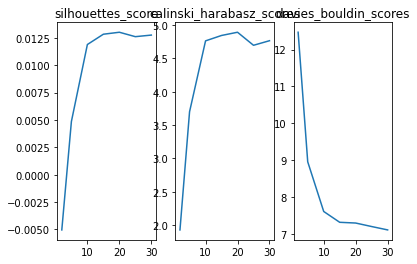

In [30]:
find_n_components_lsa()

In [40]:
n_components = 25
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_lsa, X)
labels_lsa = model_lsa.predict(X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, corpus, labels_lsa, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('classifier', 'class', 'classification', 'data', 'forest', 'tree', 'method', 'algorithm', 'random', 'label')


Cluster 1:
('algorithm', 'problem', 'convex', 'method', 'optimization', 'function', 'non', 'distributed', 'learning', 'convergence')


Cluster 2:
('model', 'learning', 'data', 'feature', 'method', 'latent', 'algorithm', 'task', 'approach', 'based')


Cluster 3:
('inference', 'model', 'gaussian', 'process', 'data', 'variational', 'method', 'prior', 'bayesian', 'approach')


Cluster 4:
('network', 'causal', 'model', 'data', 'neural', 'algorithm', 'learning', 'method', 'variable', 'effect')


Cluster 5:
('regret', 'online', 'algorithm', 'learning', 'bound', 'problem', 'bandit', 'optimal', 'loss', 'setting')


Cluster 6:
('clustering', 'algorithm', 'cluster', 'density', 'data', 'based', 'graph', 'model', 'hierarchical', 'number')


Cluster 7:
('model', 'regression', 'algorithm', 'method', 'data', 'estimator', 'high', 'dimensional', 'graphical', '

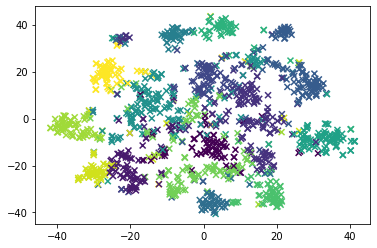

In [41]:
plot(model_lsa, X, labels_lsa, n_components=n_components)

In [42]:
n_components = 25
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
model_lsa_stopwords = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_lsa_stopwords, X)
labels_lsa_stopwords = model_lsa_stopwords.predict(X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_lsa_stopwords, vectorizer_stopwords, corpus_stopwords, labels_lsa_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('distributed', 'communication', 'regression', 'community', 'problem', 'optimization', 'optimal', 'framework', 'machine', 'error')


Cluster 1:
('causal', 'inference', 'variable', 'process', 'latent', 'gaussian', 'variational', 'approach', 'bayesian', 'effect')


Cluster 2:
('regression', 'estimator', 'high', 'selection', 'dimensional', 'lasso', 'variable', 'approach', 'function', 'estimation')


Cluster 3:
('loss', 'bound', 'online', 'regret', 'risk', 'problem', 'rate', 'function', 'setting', 'optimal')


Cluster 4:
('machine', 'library', 'python', 'package', 'toolbox', 'source', 'optimization', 'implementation', 'open', 'classification')


Cluster 5:
('kernel', 'function', 'regression', 'based', 'problem', 'rate', 'space', 'mean', 'distribution', 'sample')


Cluster 6:
('policy', 'reinforcement', 'problem', 'function', 'agent', 'control', 'action', 'based', 'task', 'value')


Cluster 7:
('problem', 'manifold', 'sample', 'subspace', 'space', 'distribu

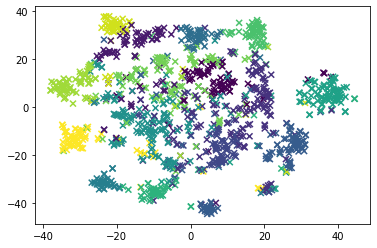

In [43]:
plot(model_lsa_stopwords, X, labels_lsa, n_components=n_components)

# Spectral Embedding

In [33]:
def find_n_components_spectral():
    n = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=n_component).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = GaussianMixture(n_components=num_topics, covariance_type="tied")
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        labels_spectral = model_spectral.predict(tfidf_corpus_spec_embedding_array)

        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral, labels_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

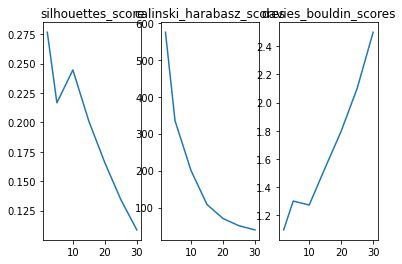

In [34]:
find_n_components_spectral()

2 is best

In [35]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [36]:
model_spectral = GaussianMixture(n_components=num_topics, covariance_type="tied")
model_spectral.fit(tfidf_corpus_spec_embedding_array)

GaussianMixture(covariance_type='tied', n_components=15)

In [37]:
labels_spectral = model_spectral.predict(tfidf_corpus_spec_embedding_array)
print(np.where(labels_spectral == 0))
clusters_spectral = print_and_get_clusters(model_spectral, vectorizer_spec_embedding, corpus, labels_spectral)

(array([], dtype=int64),)
Top terms per cluster:
Cluster 0:
no documents in cluster 0


Cluster 1:
('learning', 'algorithm', 'problem', 'method', 'function', 'optimization', 'policy', 'kernel', 'bound', 'loss')


Cluster 2:
('learning', 'machine', 'library', 'python', 'data', 'algorithm', 'model', 'toolbox', 'source', 'package')


Cluster 3:
('model', 'data', 'algorithm', 'method', 'learning', 'matrix', 'network', 'graph', 'problem', 'approach')


Cluster 4:
no documents in cluster 4


Cluster 5:
no documents in cluster 5


Cluster 6:
no documents in cluster 6


Cluster 7:
no documents in cluster 7


Cluster 8:
no documents in cluster 8


Cluster 9:
no documents in cluster 9


Cluster 10:
('learning', 'data', 'algorithm', 'model', 'package', 'machine', 'toolbox', 'task', 'set', 'image')


Cluster 11:
no documents in cluster 11


Cluster 12:
no documents in cluster 12


Cluster 13:
no documents in cluster 13


Cluster 14:
('stochastic', 'convergence', 'algorithm', 'convex', 'gradient', 

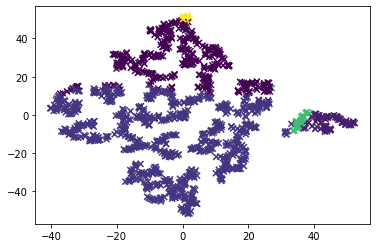

In [38]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, labels_spectral, n_components=2)

Only 5 clusters found.

# find k

In [51]:
def find_k():
    ks = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for k in ks:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = GaussianMixture(n_components=k, covariance_type="tied")
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        labels_spectral = model_spectral.predict(tfidf_corpus_spec_embedding_array)

        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral, labels_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, ks)

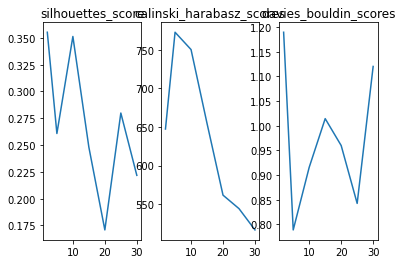

In [52]:
find_k()

# Metrics
Metrics provided from sklearn, that don't need true labels:

    metrics.silhouette_score
    metrics.calinski_harabasz_score
    metrics.davies_bouldin_score
    
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [44]:
scores = []
score = list(calc_scores(tfidf_corpus, model, labels))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords, labels_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)
score = list(calc_scores(tfidf_corpus, model_lsa, labels_lsa))
score.insert(0, 'model_lsa')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_lsa_stopwords, labels_lsa_stopwords))
score.insert(0, 'model_lsa_stopwords')
scores.append(score)
score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral, labels_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.010942                 4.575539   
1    model with custom stopwords          0.010341                 4.469231   
2                      model_lsa          0.011837                 4.757360   
3            model_lsa_stopwords          0.011856                 4.608585   
4  model with spectral embedding          0.266498               530.321537   

   davies_bouldin_score  
0              7.187345  
1              7.387664  
2              7.211851  
3              7.257676  
4              0.862369  


- kmeans achieves better scores. But with LSA the scores are better than the score of kmeans with lsa.
- the scores with spectral embedding are good, but not as good as with kmeans or birch.

In [45]:
scores.to_csv("scores/gaussian_mixture.csv")